# LSTM-arithmetic

## Dataset
- [Arithmetic dataset](https://drive.google.com/file/d/1cMuL3hF9jefka9RyF4gEBIGGeFGZYHE-/view?usp=sharing)

In [1]:
#!python -m pip install seaborn
#!python -m pip install opencc
#!python -m pip install -U scikit-learn

In [2]:
#!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn
import torch.nn.utils.rnn
import torch.utils.data
import matplotlib.pyplot as plt
import seaborn as sns
import opencc
import os
from sklearn.model_selection import train_test_split

data_path = './data'

In [4]:
df_train = pd.read_csv(os.path.join(data_path, 'arithmetic_train.csv'))
df_eval = pd.read_csv(os.path.join(data_path, 'arithmetic_eval.csv'))
df_train = df_train.drop('Unnamed: 0', axis=1)
df_eval = df_eval.drop('Unnamed: 0', axis=1)
df_train.head()

,src,tgt
0,14*(43+20)=,882
1,(6+1)*5=,35
2,13+32+29=,74
3,31*(3-11)=,-248
4,24*49+1=,1177


In [5]:
# transform the input data to string
df_train['tgt'] = df_train['tgt'].apply(lambda x: str(x))
df_train['src'] = df_train['src'].add(df_train['tgt'])
df_train['len'] = df_train['src'].apply(lambda x: len(x))

df_eval['tgt'] = df_eval['tgt'].apply(lambda x: str(x))
df_eval['src'] = df_eval['src'].add(df_eval['tgt'])
df_eval['len'] = df_eval['src'].apply(lambda x: len(x))

# Build Dictionary
 - The model cannot perform calculations directly with plain text.
 - Convert all text (numbers/symbols) into numerical representations.
 - Special tokens
    - '&lt;pad&gt;'
        - Each sentence within a batch may have different lengths.
        - The length is padded with '&lt;pad&gt;' to match the longest sentence in the batch.
    - '&lt;eos&gt;'
        - Specifies the end of the generated sequence.
        - Without '&lt;eos&gt;', the model will not know when to stop generating.

In [6]:
"""
char_to_id['<pad>'] = 0
char_to_id['<eos>'] = 1
id_to_char[0] = '<pad>'
id_to_char[1] = '<eos>'

for i in range(10):
    char_to_id[str(i)] = len(char_to_id)
    id_to_char[len(id_to_char)] = str(i)

for char in ['+', '-', '*', '(', ')', '=']:
    char_to_id[char] = len(char_to_id)
    id_to_char[len(id_to_char)] = char

vocab_size = len(char_to_id)
print('Vocab size: {}'.format(vocab_size))
"""

"\nchar_to_id['<pad>'] = 0\nchar_to_id['<eos>'] = 1\nid_to_char[0] = '<pad>'\nid_to_char[1] = '<eos>'\n\nfor i in range(10):\n    char_to_id[str(i)] = len(char_to_id)\n    id_to_char[len(id_to_char)] = str(i)\n\nfor char in ['+', '-', '*', '(', ')', '=']:\n    char_to_id[char] = len(char_to_id)\n    id_to_char[len(id_to_char)] = char\n\nvocab_size = len(char_to_id)\nprint('Vocab size: {}'.format(vocab_size))\n"

In [7]:
char_to_id = {}
id_to_char = {}

# write your code here
# Build a dictionary and give every token in the train dataset an id
# The dictionary should contain <eos> and <pad>
# char_to_id is to conver charactors to ids, while id_to_char is the opposite

char_to_id = {'<pad>': 0, '<eos>': 1}
id_to_char = {0: '<pad>', 1: '<eos>'}

unique_chars = set(''.join(df_train['src']) + ''.join(df_train['tgt']))
for char in sorted(unique_chars):
    if char not in char_to_id:
        id = len(char_to_id)
        char_to_id[char] = id
        id_to_char[id] = char

vocab_size = len(char_to_id)
print('Vocab size:', vocab_size)

print("char_to_id:", char_to_id)
print("id_to_char:", id_to_char)

Vocab size: 18
char_to_id: {'<pad>': 0, '<eos>': 1, '(': 2, ')': 3, '*': 4, '+': 5, '-': 6, '0': 7, '1': 8, '2': 9, '3': 10, '4': 11, '5': 12, '6': 13, '7': 14, '8': 15, '9': 16, '=': 17}
id_to_char: {0: '<pad>', 1: '<eos>', 2: '(', 3: ')', 4: '*', 5: '+', 6: '-', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: '='}


# Data Preprocessing
 - The data is processed into the format required for the model's input and output.
 - Example: 1+2-3=0
     - Model input: 1 + 2 - 3 = 0
     - Model output: / / / / / 0 &lt;eos&gt;  (the '/' can be replaced with &lt;pad&gt;)
     - The key for the model's output is that the model does not need to predict the next character of the previous part. What matters is that once the model sees '=', it should start generating the answer, which is '0'. After generating the answer, it should also generate&lt;eos&gt;


In [8]:
"""
char_id_list = []
label_id_list = []
for expression, answer in zip(df_train['src'], df_train['tgt']):
    char_id = []
    label_id = []
    char_id = [char_to_id[char] for char in expression]
    char_id.append(char_to_id['<eos>'])
    char_id_list.append(char_id)
    
    label_id = [char_to_id['<pad>']] * (len(expression) - len(answer))
    for char in answer:
        label_id.append(char_to_id[char])
    label_id.append(char_to_id['<eos>'])
    label_id_list.append(label_id)

df_train['char_id_list'] = char_id_list
df_train['label_id_list'] = label_id_list
df_train.head()
#df.head()
"""

"\nchar_id_list = []\nlabel_id_list = []\nfor expression, answer in zip(df_train['src'], df_train['tgt']):\n    char_id = []\n    label_id = []\n    char_id = [char_to_id[char] for char in expression]\n    char_id.append(char_to_id['<eos>'])\n    char_id_list.append(char_id)\n    \n    label_id = [char_to_id['<pad>']] * (len(expression) - len(answer))\n    for char in answer:\n        label_id.append(char_to_id[char])\n    label_id.append(char_to_id['<eos>'])\n    label_id_list.append(label_id)\n\ndf_train['char_id_list'] = char_id_list\ndf_train['label_id_list'] = label_id_list\ndf_train.head()\n#df.head()\n"

In [9]:
# Write your code here

def preprocess_data(df):
    df['char_id_list'] = df['src'].apply(lambda x: [char_to_id[c] for c in x] + [char_to_id['<eos>']])
    df['label_id_list'] = df['src'].apply(lambda x: [char_to_id['<pad>']] * (len(x) - len(x.split('=')[1])) + 
                                                    [char_to_id[c] for c in x.split('=')[1]] + 
                                                    [char_to_id['<eos>']])
    return df

df_train = preprocess_data(df_train)
df_eval = preprocess_data(df_eval)
df_train.head()
df_eval.head()

,src,tgt,len,char_id_list,label_id_list
0,48+43+34=125,125,12,"[11, 15, 5, 11, 10, 5, 10, 11, 17, 8, 9, 12, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 12, 1]"
1,30-(48+13)=-31,-31,14,"[10, 7, 6, 2, 11, 15, 5, 8, 10, 3, 17, 6, 10, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 8, 1]"
2,(21*31)+10=661,661,14,"[2, 9, 8, 4, 10, 8, 3, 5, 8, 7, 17, 13, 13, 8, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 13, 8, 1]"
3,2-27-10=-35,-35,11,"[9, 6, 9, 14, 6, 8, 7, 17, 6, 10, 12, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 12, 1]"
4,(15*20)+24=324,324,14,"[2, 8, 12, 4, 9, 7, 3, 5, 9, 11, 17, 10, 9, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 9, 11, 1]"


# Hyper Parameters

|Hyperparameter|Meaning|Value|
|-|-|-|
|`batch_size`|Number of data samples in a single batch|64|
|`epochs`|Total number of epochs to train|10|
|`embed_dim`|Dimension of the word embeddings|256|
|`hidden_dim`|Dimension of the hidden state in each timestep of the LSTM|256|
|`lr`|Learning Rate|0.001|
|`grad_clip`|To prevent gradient explosion in RNNs, restrict the gradient range|1|

In [10]:
batch_size = 64
epochs = 10
embed_dim = 256
hidden_dim = 256
lr = 0.0005
grad_clip = 1

# Data Batching
- Use `torch.utils.data.Dataset` to create a data generation tool called  `dataset`.
- The, use `torch.utils.data.DataLoader` to randomly sample from the `dataset` and group the samples into batches.

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        # return the amount of data
        return len(self.sequences)
    
    def __getitem__(self, index):
        # Extract the input data x and the ground truth y from the data
        # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html
        
        x = [char_to_id['<eos>']] + self.sequences.iloc[index]['char_id_list']   
        y = self.sequences.iloc[index]['label_id_list'] + [char_to_id['<pad>']]
        
        #x = x[:x.index(char_to_id['=']) + 1] + [char_to_id['<pad>']] * (len(x) - x.index(char_to_id['=']) - 2) + [char_to_id['<eos>']]
        #y = y[(max([i for i, label in enumerate(y) if label == char_to_id['<pad>']], default=-1) + 1):]
        #print(x)
        #print(y)
        #print("--------------------")
        return x, y

# collate function, used to build dataloader
def collate_fn(batch):
    batch_x = [torch.tensor(data[0]) for data in batch]
    batch_y = [torch.tensor(data[1]) for data in batch]
    batch_x_lens = torch.LongTensor([len(x) for x in batch_x])
    batch_y_lens = torch.LongTensor([len(y) for y in batch_y])
    
    # Pad the input sequence
    pad_batch_x = torch.nn.utils.rnn.pad_sequence(batch_x,
                                                  batch_first=True,
                                                  padding_value=char_to_id['<pad>'])
    
    pad_batch_y = torch.nn.utils.rnn.pad_sequence(batch_y,
                                                  batch_first=True,
                                                  padding_value=char_to_id['<pad>'])
    
    return pad_batch_x, pad_batch_y, batch_x_lens, batch_y_lens

In [12]:
ds_train = Dataset(df_train[['char_id_list', 'label_id_list']])
ds_eval = Dataset(df_eval[['char_id_list', 'label_id_list']])

In [13]:
# Build dataloader of train set and eval set, collate_fn is the collate function
dl_train = torch.utils.data.DataLoader(ds_train, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       collate_fn=collate_fn)

dl_eval = torch.utils.data.DataLoader(ds_eval, 
                                      batch_size=batch_size,
                                      shuffle=False, 
                                      collate_fn=collate_fn)

# Model Design

## Execution Flow
1. Convert all characters in the sentence into embeddings.
2. Pass the embeddings through an LSTM sequentially.
3. The output of the LSTM is passed into another LSTM, and additional layers can be added.
4. The output from all time steps of the final LSTM is passed through a Fully Connected layer.
5. The character corresponding to the maximum value across all output dimensions is selected as the next character.

## Loss Function
Since this is a classification task, Cross Entropy is used as the loss function.

## Gradient Update
Adam algorithm is used for gradient updates.

In [14]:
class CharRNN(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CharRNN, self).__init__()
        
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                            embedding_dim=embed_dim,
                                            padding_idx=char_to_id['<pad>'])
        
        self.rnn_layer1 = torch.nn.LSTM(input_size=embed_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)
        
        self.rnn_layer2 = torch.nn.LSTM(input_size=hidden_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)
        
        self.linear = torch.nn.Sequential(torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=hidden_dim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=vocab_size))

    def forward(self, batch_x, batch_x_lens):
        return self.encoder(batch_x, batch_x_lens)
    
    # The forward pass of the model
    def encoder(self, batch_x, batch_x_lens):
        batch_x = self.embedding(batch_x)
        
        batch_x = torch.nn.utils.rnn.pack_padded_sequence(batch_x,
                                                          batch_x_lens,
                                                          batch_first=True,
                                                          enforce_sorted=False)
        
        batch_x, _ = self.rnn_layer1(batch_x)
        batch_x, _ = self.rnn_layer2(batch_x)
        
        batch_x, _ = torch.nn.utils.rnn.pad_packed_sequence(batch_x,
                                                            batch_first=True)
        
        batch_x = self.linear(batch_x)
        
        return batch_x
    
    def generator(self, start_char, max_len=200):
        
        char_list = [char_to_id[c] for c in start_char]
        
        next_char = None
        
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        while len(char_list) < max_len: 
            # Write your code here 
            # Pack the char_list to tensor
            # Input the tensor to the embedding layer, LSTM layers, linear respectively
            #x = torch.tensor(char_to_id['<eos>'] + char_list).unsqueeze(0)
            x = torch.tensor([char_to_id['<eos>']] + char_list).unsqueeze(0)

            x = self.embedding(x)
            x1, _ = self.rnn_layer1(x)
            x2, _ = self.rnn_layer2(x1)
            out = self.linear(x2) 
            next_char = torch.argmax(out[0, -1]).item()
            
            if next_char == char_to_id['<eos>']:
                break
            
            char_list.append(next_char)
            
        return [id_to_char[ch_id] for ch_id in char_list]

In [15]:
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = CharRNN(vocab_size,
                embed_dim,
                hidden_dim).to(device)

cuda


In [16]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=char_to_id['<pad>'])

#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0)

# Training
1. The outer `for` loop controls the `epoch`
    1. The inner `for` loop uses `data_loader` to retrieve batches.
        1. Pass the batch to the `model` for training.
        2. Compare the predicted results `batch_pred_y` with the true labels `batch_y` using Cross Entropy to calculate the loss `loss`
        3. Use `loss.backward` to automatically compute the gradients.
        4. Use `torch.nn.utils.clip_grad_value_` to limit the gradient values between `-grad_clip` &lt; and &lt; `grad_clip`.
        5. Use `optimizer.step()` to update the model (backpropagation).
2.  After every `1000` batches, output the current loss to monitor whether it is converging.

Validation epoch 1: 100%|███████████████████████████████████████████████████████████| 4114/4114 [00:49<00:00, 83.00it/s]


Epoch 1
Training - Loss: 0.5442, Accuracy: 0.4114
Validation - Loss: 0.3627, Accuracy: 0.5599
--------------------------------------------------


Train epoch 2:  16%|████████▍                                          | 6083/37020 [02:05<10:45, 47.96it/s, loss=0.384]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Validation epoch 4: 100%|███████████████████████████████████████████████████████████| 4114/4114 [00:49<00:00, 82.97it/s]


Epoch 4
Training - Loss: 0.1617, Accuracy: 0.7850
Validation - Loss: 0.1460, Accuracy: 0.8037
--------------------------------------------------


Validation epoch 5: 100%|███████████████████████████████████████████████████████████| 4114/4114 [00:49<00:00, 82.76it/s]


Epoch 5
Training - Loss: 0.1202, Accuracy: 0.8411
Validation - Loss: 0.1490, Accuracy: 0.8140
--------------------------------------------------


Validation epoch 6: 100%|███████████████████████████████████████████████████████████| 4114/4114 [00:49<00:00, 82.53it/s]


Epoch 6
Training - Loss: 0.1004, Accuracy: 0.8683
Validation - Loss: 0.0946, Accuracy: 0.8768
--------------------------------------------------


Validation epoch 7: 100%|███████████████████████████████████████████████████████████| 4114/4114 [00:49<00:00, 82.86it/s]


Epoch 7
Training - Loss: 0.0878, Accuracy: 0.8860
Validation - Loss: 0.0878, Accuracy: 0.8900
--------------------------------------------------


Validation epoch 8: 100%|███████████████████████████████████████████████████████████| 4114/4114 [00:49<00:00, 83.04it/s]


Epoch 8
Training - Loss: 0.0787, Accuracy: 0.8990
Validation - Loss: 0.0734, Accuracy: 0.9089
--------------------------------------------------


Validation epoch 9: 100%|███████████████████████████████████████████████████████████| 4114/4114 [00:49<00:00, 82.92it/s]


Epoch 9
Training - Loss: 0.0715, Accuracy: 0.9088
Validation - Loss: 0.0701, Accuracy: 0.9112
--------------------------------------------------


Validation epoch 10: 100%|██████████████████████████████████████████████████████████| 4114/4114 [00:49<00:00, 82.35it/s]


Epoch 10
Training - Loss: 0.0661, Accuracy: 0.9164
Validation - Loss: 0.0937, Accuracy: 0.8799
--------------------------------------------------


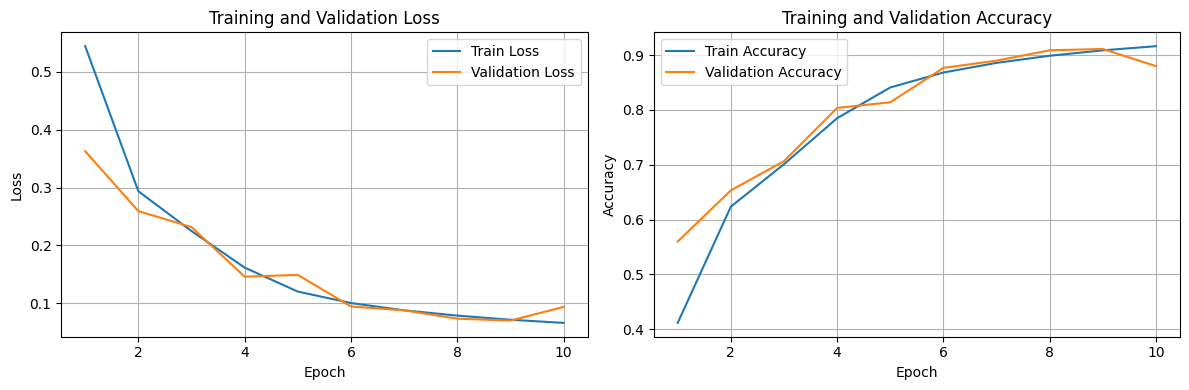

In [17]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []

model = model.to(device)
model.train()
i = 0
best = 0

for epoch in range(1, epochs+1):
    epoch_train_losses = []
    epoch_train_matched = 0
    epoch_train_total = 0
    
    bar = tqdm(dl_train, desc=f"Train epoch {epoch}")
    for batch_x, batch_y, batch_x_lens, batch_y_lens in bar:
        # Clear the gradient
        optimizer.zero_grad()
        
        batch_pred_y = model(batch_x.to(device), batch_x_lens)
        predictions = torch.argmax(batch_pred_y, dim=-1).to(device)
        answer = batch_y.to(device)
        
        # Input the prediction and ground truths to loss function here
        batch_pred_y = batch_pred_y.view(-1, vocab_size)
        batch_y = batch_y.to(device).view(-1)
        loss = criterion(batch_pred_y, batch_y)
        
        # Record training loss
        epoch_train_losses.append(loss.item())
        
        # Calculate training accuracy
        for pred, target in zip(predictions, answer):
            non_zero_indices = torch.nonzero(target, as_tuple=True)[0]
            if torch.all(pred[non_zero_indices] == target[non_zero_indices]):
                epoch_train_matched += 1
            epoch_train_total += 1
        
        # Back propagation
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        
        i+=1
        if i%50==0:
            bar.set_postfix(loss = loss.item())
    
    # Record
    train_losses.append(sum(epoch_train_losses) / len(epoch_train_losses))
    train_accuracies.append(epoch_train_matched / epoch_train_total)
    
    # Evaluate
    bar = tqdm(dl_eval, desc=f"Validation epoch {epoch}")
    matched = 0
    total = 0
    epoch_eval_losses = []
    
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y, batch_x_lens, batch_y_lens in bar:
            predictions = model(batch_x.to(device), batch_x_lens)
            
            # Calculate validation loss
            val_loss = criterion(predictions.view(-1, vocab_size), 
                               batch_y.to(device).view(-1))
            epoch_eval_losses.append(val_loss.item())
            
            predictions = torch.argmax(predictions, dim=-1)
            
            for i in range(len(predictions)):
                non_zero_indices = torch.nonzero(batch_y[i], as_tuple=True)[0]
                if torch.all(predictions[i][non_zero_indices] == batch_y[i][non_zero_indices].to(device)):
                    matched += 1
                total += 1

    current_eval_acc = matched / total
    if current_eval_acc > best:
        best = current_eval_acc
        best_model_weights = deepcopy(model.state_dict())
        best_model_epoch = epoch
    
    # Record
    eval_losses.append(sum(epoch_eval_losses) / len(epoch_eval_losses))
    eval_accuracies.append(current_eval_acc)
    
    model.train()
    print(f"Epoch {epoch}")
    print(f"Training - Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}")
    print(f"Validation - Loss: {eval_losses[-1]:.4f}, Accuracy: {eval_accuracies[-1]:.4f}")
    print("-" * 50)

plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), eval_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Generation
Use `model.generator` and provide an initial character to automatically generate a sequence.

In [18]:
model.load_state_dict(best_model_weights)

<All keys matched successfully>

In [19]:
model = model.to("cpu")
print("".join(model.generator('1+1=')))

1+1=2


In [20]:
# Extra : Test generation accuracy in different way 
# Code generated by ChatGPT

import random

def evaluate_model(model, train_range=(1, 50), test_range=(50, 100)):
    correct_add = 0
    correct_sub = 0
    correct_mul = 0
    total = 0

    sub_positive_correct = 0
    sub_negative_correct = 0
    sub_positive_total = 0
    sub_negative_total = 0

    outside_correct_add = 0
    outside_correct_sub = 0
    outside_correct_mul = 0
    outside_total = 0
    
    # 遍歷1~50的數字，並進行加、減、乘運算
    for a in range(train_range[0], train_range[1] + 1):
        for b in range(train_range[0], train_range[1] + 1):
            # 加法運算
            correct_add += evaluate_operation(model, a, b, '+', a + b)
            # 減法運算
            correct_sub += evaluate_operation(model, a, b, '-', a - b)
            # 減法正負數分析
            if a - b >= 0:
                sub_positive_total += 1
                sub_positive_correct += evaluate_operation(model, a, b, '-', a - b)
            else:
                sub_negative_total += 1
                sub_negative_correct += evaluate_operation(model, a, b, '-', a - b)
            # 乘法運算
            correct_mul += evaluate_operation(model, a, b, '*', a * b)
            total += 1

    # 測試模型在範圍外的表現，隨機從50~100之間抽樣數字
    for _ in range(100):  # 測試100次
        a = random.randint(test_range[0], test_range[1])
        b = random.randint(test_range[0], test_range[1])
        
        outside_correct_add += evaluate_operation(model, a, b, '+', a + b)
        outside_correct_sub += evaluate_operation(model, a, b, '-', a - b)
        outside_correct_mul += evaluate_operation(model, a, b, '*', a * b)
        outside_total += 1

    # 計算並輸出正確率
    print(f"加法運算正確率: {correct_add / total:.2%}")
    print(f"減法運算正確率: {correct_sub / total:.2%}")
    print(f"乘法運算正確率: {correct_mul / total:.2%}")
    
    # 正負數的減法運算分析
    if sub_positive_total > 0:
        print(f"減法運算（正數結果）正確率: {sub_positive_correct / sub_positive_total:.2%}")
    if sub_negative_total > 0:
        print(f"減法運算（負數結果）正確率: {sub_negative_correct / sub_negative_total:.2%}")

    # 範圍外數字的測試結果
    print(f"範圍外加法運算正確率: {outside_correct_add / outside_total:.2%}")
    print(f"範圍外減法運算正確率: {outside_correct_sub / outside_total:.2%}")
    print(f"範圍外乘法運算正確率: {outside_correct_mul / outside_total:.2%}")

def evaluate_operation(model, a, b, operator, correct_result):
    """生成算式並比較模型的輸出與正確結果"""
    equation = f"{a}{operator}{b}="
    model_output = "".join(model.generator(equation))  # 使用模型生成答案
    model_answer = parse_model_output(model_output)

    # 將模型的結果與正確答案比較
    if model_answer == str(correct_result):
        return 1
    else:
        return 0

def parse_model_output(output):
    """解析模型輸出的字串，提取等號後到 <eos> 前的部分，並轉換回原本的答案，再轉回 int 型別"""
    result = ""
    capture = False
    for char in output:
        if char == '=':
            capture = True  # 開始在等號之後提取
            continue
        if capture:
            result += char
    
    try:
        return result  # 將答案轉回 int
    except ValueError:
        return None  # 如果轉換失敗，回傳 None
evaluate_model(model)

加法運算正確率: 94.92%
減法運算正確率: 95.52%
乘法運算正確率: 74.72%
減法運算（正數結果）正確率: 95.53%
減法運算（負數結果）正確率: 95.51%
範圍外加法運算正確率: 0.00%
範圍外減法運算正確率: 6.00%
範圍外乘法運算正確率: 0.00%


In [ ]:
"""
# Save Weights
import pickle

with open('best_model_weights.pkl', 'wb') as f:
    pickle.dump(best_model_weights, f)
"""

In [ ]:
""" 
# Using RNN GRU
class CharRNN(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CharRNN, self).__init__()
        
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                            embedding_dim=embed_dim,
                                            padding_idx=char_to_id['<pad>'])
        
        self.rnn_layer1 = torch.nn.RNN(input_size=embed_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)
        
        self.rnn_layer2 = torch.nn.RNN(input_size=hidden_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)
        
        self.linear = torch.nn.Sequential(torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=hidden_dim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=vocab_size))

    def forward(self, batch_x, batch_x_lens):
        return self.encoder(batch_x, batch_x_lens)
    
    # The forward pass of the model
    def encoder(self, batch_x, batch_x_lens):
        batch_x = self.embedding(batch_x)
        
        batch_x = torch.nn.utils.rnn.pack_padded_sequence(batch_x,
                                                          batch_x_lens,
                                                          batch_first=True,
                                                          enforce_sorted=False)
        
        batch_x, _ = self.rnn_layer1(batch_x)
        batch_x, _ = self.rnn_layer2(batch_x)
        
        batch_x, _ = torch.nn.utils.rnn.pad_packed_sequence(batch_x,
                                                            batch_first=True)
        
        batch_x = self.linear(batch_x)
        
        return batch_x
    
    def generator(self, start_char, max_len=200):
        
        char_list = [char_to_id[c] for c in start_char]
        
        next_char = None
        
        # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        while len(char_list) < max_len: 
            # Write your code here 
            # Pack the char_list to tensor
            # Input the tensor to the embedding layer, GRU layers, linear respectively
            x = torch.tensor([char_to_id['<eos>']] + char_list).unsqueeze(0)

            x = self.embedding(x)
            h1 = torch.zeros(1, 1, hidden_dim)  # Initial hidden state for GRU
            x1, _ = self.rnn_layer1(x, h1)
            h2 = torch.zeros(1, 1, hidden_dim)  # Initial hidden state for GRU
            x2, _ = self.rnn_layer2(x1, h2)
            out = self.linear(x2) 
            next_char = torch.argmax(out[0, -1]).item()
            
            if next_char == char_to_id['<eos>']:
                break
            
            char_list.append(next_char)
            
        return [id_to_char[ch_id] for ch_id in char_list]
"""